# Initialize GPU

In [ ]:
import os, gc
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import tensorflow as tf
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
print('TensorFlow version =',tf.__version__)

# USE MULTIPLE GPUS
gpus = tf.config.list_physical_devices('GPU')
if len(gpus)<=1:
    strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    print(f'Using {len(gpus)} GPU')
else:
    strategy = tf.distribute.MirroredStrategy()
    print(f'Using {len(gpus)} GPUs')

# USE MIXED PRECISION
MIX = True
if MIX:
    tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
    print('Mixed precision enabled')
else:
    print('Using full precision')

# Load Train Data and Create Non-Overlapping Eeg Ids

In [ ]:
df = pd.read_csv('/kaggle/input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df.columns[-6:]
print('Train shape:', df.shape )
print('Targets', list(TARGETS))

###########

train = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_id':'first','spectrogram_label_offset_seconds':'min'})
train.columns = ['spec_id','min']

tmp = df.groupby('eeg_id')[['spectrogram_id','spectrogram_label_offset_seconds']].agg(
    {'spectrogram_label_offset_seconds':'max'})
train['max'] = tmp

tmp = df.groupby('eeg_id')[['eeg_label_offset_seconds']].agg('min')
train['min_eeg'] = tmp

tmp = df.groupby('eeg_id')[['eeg_label_offset_seconds']].agg('max')
train['max_eeg'] = tmp

tmp = df.groupby('eeg_id')[['patient_id']].agg('first')
train['patient_id'] = tmp

tmp = df.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    train[t] = tmp[t].values

y_data = train[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

tmp = df.groupby('eeg_id')[['expert_consensus']].agg('first')
train['target'] = tmp

train = train.reset_index()

data_PATH = '/kaggle/input/hms-harmful-brain-activity-classification/'
train['path_eeg']=train['eeg_id'].apply(lambda x: os.path.join(data_PATH,"train_eegs/"+str(x)+".parquet" ))

print('Train non-overlapp eeg_id shape:', train.shape )
train.head()

# Feature engineering

As seen in this article[Metadata_notebook/Wavelets_for_EEG_Analysis.pdf],  wavelet analysis is wellsuited for EEG signals for describing time-localised event

Therefore, I'm going to compute Scalograms & Spectrograms and use them as a features

For that I decided to recreate the 4 LL, LP, RP, RL componants from the EEGs:

![Spatialisation](Metadata_notebook/tileshop.jpg)
![Spatialisation_2](Metadata_notebook/10-20-system-of-electrode-placement.png)

The scalp is divided into 4 different regions for spectrogram construction: Left lateral (Fp1, F7, T3, T5, O10); right lateral (Fp2, F8, T4, T6, O2); left parasagittal (Fp1, F3, C3, P3, O1); right parasagittal (Fp2, F4, C4, P4, O2). Each spectrogram image has four panels: left lateral (LL), right lateral (RL), left parasagittal (LP), right parasagittal (RP).

We extract each region from EEG data with this formula:

```LL Spec = ( spec(Fp1 - F7) + spec(F7 - T3) + spec(T3 - T5) + spec(T5 - O1) )/4. ```

```LL Scalo = ( scalo(Fp1 - F7) + scalo(F7 - T3) + scalo(T3 - T5) + scalo(T5 - O1) )/4. ```

# Scalograms

## Scalogram creation

In [ ]:
import scipy, librosa
import matplotlib.pyplot as plt
import pywt

NAMES = ['LL','LP','RP','RR']

FEATS = [['Fp1','F7','T3','T5','O1'],
         ['Fp1','F3','C3','P3','O1'],
         ['Fp2','F8','T4','T6','O2'],
         ['Fp2','F4','C4','P4','O2']]


def scalogram_from_eeg(parquet_path, eeg_offset, eeg_id, display=False):

    # LOAD MIDDLE 8.533 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)

    middle = eeg_offset*200+5000
    eeg = eeg.iloc[middle-853:middle+853]

    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,512,4),dtype='float32')

    signals = []
    for k in range(4):
        COLS = FEATS[k]

        for kk in range(4):

            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            # UNDERSAMPLE SIGNAL 200Hz to 60Hz (minimum sr for not loosing information on the 0-30Hz bandwith (shanon-nyquist))
            x  = scipy.signal.resample(x, 512)

            # RAW SPECTROGRAM
            fs = 60
            frequencies = np.linspace(0.2, 30, 128) / fs # normalize
            scale = pywt.frequency2scale('cmor1-0.5', frequencies)
            scalo , freqs = pywt.cwt(x, scale, 'cmor1-0.5', sampling_period = 1/fs)

            # LOG TRANSFORM
            width = (scalo.shape[1]//32)*32
            scalo_db = librosa.power_to_db(np.abs(scalo), ref=1).astype(np.float32)[:,:width]

            img[:,:,k] += scalo_db

        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0

        # STANDARDIZE PER IMAGE
        ep = 1e-6
        m = np.nanmean(img.flatten())
        s = np.nanstd(img.flatten())
        img = (img-m)/(s+ep)
        img = np.nan_to_num(img, nan=0.0)

        if display:
            plt.subplot(2,2,k+1)
            plt.imshow(img[:,:,k],aspect='auto',origin='lower')
            plt.title(f'EEG {eeg_id} - Scalogram {NAMES[k]}')
            plt.show()

    return img

In [ ]:

import cv2 as cv

scalos = {}
for index, row in train.iterrows():
        r = int( (row['min_eeg'] + row['max_eeg'])//4 )
        parquet_path = row['path_eeg']
        eeg_id = row['eeg_id']
        print(index, row['target'])
        img = scalogram_from_eeg(parquet_path, r, eeg_id, display=False)
        resized = np.zeros((128,256,4))
        for i in range(4):
            resized[:,:,i] = cv.resize(img[:,:,i], (256,128))
        scalos[eeg_id] = resized



np.save("scalos.npy", scalos)

In [ ]:
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()

drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
    file_metadata = {
      'name': name,
      'mimeType': 'application/octet-stream'
     }

    media = MediaFileUpload(path,
                    mimetype='application/octet-stream',
                    resumable=True)

    created = drive_service.files().create(body=file_metadata,
                                   media_body=media,
                                   fields='id').execute()

    print('File ID: {}'.format(created.get('id')))

    return created

save_file_to_drive("scalos.npy","scalos.npy")

## Read scalograms

In [ ]:
READ_SCALO_FILE = True

from google.colab import drive
drive.mount('/content/drive/')

if READ_SCALO_FILE:
    with open('/content/drive/MyDrive/scalos.npy', 'rb') as f:
        scalograms = np.load(f,allow_pickle=True).item()

# Spectrograms

## Create Spectrograms

In [ ]:
def spectrogram_from_eeg(parquet_path):

    # LOAD MIDDLE 50 SECONDS OF EEG SERIES
    eeg = pd.read_parquet(parquet_path)
    middle = (len(eeg)-10_000)//2
    eeg = eeg.iloc[middle:middle+10_000]

    # VARIABLE TO HOLD SPECTROGRAM
    img = np.zeros((128,256,4),dtype='float32')

    signals = []
    for k in range(4):
        COLS = FEATS[k]

        for kk in range(4):

            # COMPUTE PAIR DIFFERENCES
            x = eeg[COLS[kk]].values - eeg[COLS[kk+1]].values

            # FILL NANS
            m = np.nanmean(x)
            if np.isnan(x).mean()<1: x = np.nan_to_num(x,nan=m)
            else: x[:] = 0

            signals.append(x)

            # RAW SPECTROGRAM
            mel_spec = librosa.feature.melspectrogram(y=x, sr=200, hop_length=len(x)//256,
                  n_fft=1024, n_mels=128, fmin=0, fmax=20, win_length=128)

            # LOG TRANSFORM
            width = (mel_spec.shape[1]//32)*32
            mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max).astype(np.float32)[:,:width]

            # STANDARDIZE TO -1 TO 1
            mel_spec_db = (mel_spec_db+40)/40
            img[:,:,k] += mel_spec_db

        # AVERAGE THE 4 MONTAGE DIFFERENCES
        img[:,:,k] /= 4.0


    return img

In [ ]:
spectrograms = {}
for index, row in train.iterrows():
        r = int( (row['min_eeg'] + row['max_eeg'])//4 )
        parquet_path = row['path_eeg']
        eeg_id = row['eeg_id']
        print(index, row['target'])
        img = spectrogram_from_eeg(parquet_path, r, eeg_id, display=False)
        resized = np.zeros((128,256,4))
        for i in range(4):
            resized[:,:,i] = cv.resize(img[:,:,i], (256,128))
        spectrograms[eeg_id] = resized



np.save("spectrograms.npy", spectrograms)
save_file_to_drive("spectrograms.npy","spectrograms.npy")

## Read Train Spectrograms

In [ ]:
READ_KAGGLE_SPECS = False

# READ KAGGLE SPECTROGRAMS
PATH = '/kaggle/input/hms-harmful-brain-activity-classification/train_spectrograms/'
files = os.listdir(PATH)
print(f'There are {len(files)} spectrogram parquets')

if READ_KAGGLE_SPECS:
    spectrograms = {}
    for i,f in enumerate(files):
        if i%100==0: print(i,', ',end='')
        tmp = pd.read_parquet(f'{PATH}{f}')
        name = int(f.split('.')[0])
        spectrograms[name] = tmp.iloc[:,1:].values
else:
    with open('/content/drive/MyDrive/spectrograms.npy', 'rb') as f:
          spectrograms = np.load(f,allow_pickle=True).item()


# DataLoader

In [ ]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3):
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if input_img.ndim == 3:
            c = np.zeros((h, w, img_c))
        if input_img.ndim == 2:
            c = np.zeros((h, w))

        input_img[top:top + h, left:left + w] = c

        return input_img

    return eraser

In [ ]:

TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
TARS2 = {x:y for y,x in TARS.items()}

class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data, batch_size=32, shuffle=False, augment=False, mode='train',
                 specs = spectrograms, scalos = scalograms):

        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.mode = mode
        self.specs = specs
        self.scalos = scalograms
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = int( np.ceil( len(self.data) / self.batch_size ) )
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        if self.augment: X = self.__augment_batch(X)
        if self.mode!='test':
          return X, y
        else:
          return X

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange( len(self.data) )
        if self.shuffle: np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        'Generates data containing batch_size samples'

        X = np.zeros((len(indexes),128,256,8),dtype='float32')
        y = np.zeros((len(indexes),6),dtype='float32')
        if self.mode=='test':
          self.y = y
        img = np.ones((128,256),dtype='float32')

        for j,i in enumerate(indexes):
            row = self.data.iloc[i]
            if self.mode=='test':
                r = int( (row['min'] + row['max'])//4 )
            else:
                r = int( (row['min'] + row['max'])//4 )
            if READ_KAGGLE_SPECS:
              for k in range(4):
                  # EXTRACT 300 ROWS OF SPECTROGRAM
                  img = self.specs[row.spec_id][r:r+300,k*100:(k+1)*100].T

                  # LOG TRANSFORM SPECTROGRAM
                  img = np.clip(img,np.exp(-4),np.exp(8))
                  img = np.log(img)

                  # STANDARDIZE PER IMAGE
                  ep = 1e-6
                  m = np.nanmean(img.flatten())
                  s = np.nanstd(img.flatten())
                  img = (img-m)/(s+ep)
                  img = np.nan_to_num(img, nan=0.0)

                  # CROP TO 256 TIME STEPS
                  X[j,14:-14,:,k] = img[:,22:-22] / 2.0

            else:
              img = self.specs[row.eeg_id]
              X[j,:,:,:4] = img

            # EEG SCALOGRAMS
            img = self.scalos[row.eeg_id]
            X[j,:,:,4:] = img

            if self.mode!='test':
                y[j,] = row[TARGETS]
            if self.mode == 'test':
                self.y[j,] = row[TARGETS]

            x1 = [X[:,:,:,i:i+1] for i in range(4)]
            x1 = tf.keras.layers.Concatenate(axis=1)(x1)
            # EEG SPECTROGRAMS
            x2 = [X[:,:,:,i+4:i+5] for i in range(4)]
            x2 = tf.keras.layers.Concatenate(axis=1)(x2)
            # MAKE 512X512X3
            x = tf.keras.layers.Concatenate(axis=2)([x1,x2])
            x = tf.keras.layers.Concatenate(axis=3)([x])

        return x,y

    def __augment_batch(self, img_batch):
        eraser = get_random_eraser()
        img_batch = img_batch.numpy()
        for i in range(img_batch.shape[0]):

            img_batch[i, ] = eraser(img_batch[i, ])
        return tf.convert_to_tensor(img_batch)

# Effnet

In [ ]:
! pip install tf-models-official

In [ ]:

def build_model(pretrain=None):

    inp = tf.keras.Input(shape=(512,512,1))
    base_model =  tf.keras.applications.efficientnet.EfficientNetB0(weights=None,
                                                                input_shape=None,
                                                                classes=6,
                                                                classifier_activation='softmax')


    if pretrain:
        base_model.load_weights(pretrain)


    # OUTPUT
    x = base_model(inp)
    # x = tf.keras.layers.GlobalAveragePooling2D()(x0)
    # x = tf.keras.layers.Dense(6,activation='softmax', dtype='float32')(x)

    # COMPILE MODEL
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate = 1e-3)
    loss = tf.keras.losses.KLDivergence()

    model.compile(loss=loss, optimizer = opt)

    return model

# MixNet

Implementation based on: [Mixed Link Networks](https://arxiv.org/pdf/1802.01808.pdf)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np

INPUT_SHAPE = (512,512,1)




def Conv2D_Input(x, filters):
    x = layers.Conv2D(filters,
                (7,7),
                strides=2,
                input_shape=INPUT_SHAPE, kernel_initializer=tf.keras.initializers.HeNormal())(x)
    x = layers.MaxPooling2D(pool_size=(3, 3),
                            strides=2)(x)
    return x

def Conv2D_transition(x, k):
    x = layers.Conv2D(k,
                (1,1),
                padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(x)
    x = layers.AveragePooling2D(pool_size=(2, 2),
                            strides=2,
                            padding='valid')(x)
    return x


def MLBlock(x,k1,k2):
    input_ = x

    x_add = layers.BatchNormalization()(x)
    x_add = layers.ReLU()(x_add)
    x_add = layers.Conv2D(k1,
                (1, 1),
                padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(x_add)
    x_add = layers.BatchNormalization()(x_add)
    x_add = layers.ReLU()(x_add)
    x_add = layers.Conv2D(k1,
                (3, 3),
                padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(x_add)


    x_concat = layers.BatchNormalization()(x)
    x_concat = layers.ReLU()(x_concat)
    x_concat = layers.Conv2D(k2,
                (1, 1),
                padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(x_concat)
    x_concat = layers.BatchNormalization()(x_concat)
    x_concat = layers.ReLU()(x_concat)
    x_concat = layers.Conv2D(k2,
                (3, 3),
                padding='same', kernel_initializer=tf.keras.initializers.HeNormal())(x_concat)
    x_add = layers.Add()([x[:,:,:,-k1:], x_add])
    x = layers.Concatenate(axis=3)([x[:,:,:,:-k1], x_add])

    x = layers.Concatenate(axis=3)([x, x_concat])
    return x

def build_MixNet_model(k,MLB1,MLB2,MLB3,MLB4):
    global strategy
    with strategy.scope():
        # inputs
        inputs = layers.Input(shape=INPUT_SHAPE)

        x_0 = layers.BatchNormalization()(inputs)
        x_1 = Conv2D_Input(x_0, 2*k)

        for i in range(MLB1):
            x_1 = MLBlock(x_1,k,k)
            x_1 = MLBlock(x_1,k,k)

#         x_1 = layers.Dropout(0.2)(x_1)
        x_2 = Conv2D_transition(x_1, k)

        for i in range(MLB2):
            x_2 = MLBlock(x_2,k,k)
            x_2 = MLBlock(x_2,k,k)

#         x_2 = layers.Dropout(0.2)(x_2)
        x_3 = Conv2D_transition(x_2, k)

        for i in range(MLB3):
            x_3 = MLBlock(x_3,k,k)
            x_3 = MLBlock(x_3,k,k)
#         x_3 = layers.Dropout(0.2)(x_3)
        x_4 = Conv2D_transition(x_3, k)

        for i in range(MLB4):
            x_4 = MLBlock(x_4,k,k)
            x_4 = MLBlock(x_4,k,k)

        x_4 = layers.BatchNormalization()(x_1)
        x_4 = layers.ReLU()(x_4)
        x_pooled = layers.GlobalAveragePooling2D(data_format='channels_last')(x_4)

        outputs = layers.Dense(6, activation='softmax', kernel_initializer=tf.keras.initializers.HeNormal())(x_pooled)

        model = tf.keras.Model(inputs, outputs, name="ML-Net")
        opt = tf.keras.optimizers.Adam()
        loss = tf.keras.losses.KLDivergence()

        model.compile(loss=loss, optimizer = opt)

    return model

# AdaBoost_CNN

Implementation based on:

[AdaBoost-CNN: An adaptive boosting algorithm for convolutional neural networks to
classify multi-class imbalanced datasets using transfer learning](https://pure.ulster.ac.uk/ws/portalfiles/portal/78735598/AdaBoost_CNN_Aboozar.pdf)

## Weak CNN classifier

### AlexNet

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np

INPUT_SHAPE = (512,512,1)




def Conv2D(x, filters, kernel_size, stride, dropout_rate, maxpool = False):
    x = layers.Conv2D(filters,
                kernel_size,
                strides=stride,
                kernel_initializer=tf.keras.initializers.HeNormal(),
                padding = 'same')(x)
    if maxpool:
      x = layers.MaxPooling2D(pool_size=4)(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    return x


def AlexNet_weak_classifier():

    inputs = layers.Input(shape=INPUT_SHAPE)
    x_norm = layers.BatchNormalization()(inputs)
    x = Conv2D(x_norm, 48, 11, 8, 0.5, maxpool = True)
    x = Conv2D(x, 128, 5, 1, 0.5, maxpool = True)
    x = Conv2D(x, 256, 3, 1, 0.5)
    x = Conv2D(x, 256, 3, 1, 0.5)
    x = Conv2D(x, 200, 3, 1, 0.5, maxpool = True)
    x = layers.GlobalAveragePooling2D(data_format='channels_last')(x)
    x = layers.Dense(1028, activation='relu')(x)
    x = layers.Dense(1028, activation='relu')(x)
    outputs = layers.Dense(6, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    return model


## AdaBoost CNN

In [ ]:
from keras import backend as K

class AdaBoost_CNN():
    def __init__(self, weak_classifier, nbr_classifiers, nbr_data_samples):
      self.D = np.ones(nbr_data_samples, dtype=np.float32)/nbr_data_samples
      self.weak_classifier = weak_classifier
      with strategy.scope():
        self.weak_classifiers = [weak_classifier() for i in range(nbr_classifiers)]

    def get_model(self, i):
      global strategy
      model = self.weak_classifiers[i]
      if i != 0:
        prev_model = self.weak_classifiers[i-1]
        weights = prev_model.get_weights()
        model.set_weights(weights)
      return model

    def update_D(self, learning_rate, y_true, y_pred):
      # Displace zero probabilities so the log is defined.
      # Also fix negative elements which may occur with
      # negative sample weights.
      y_pred[y_pred < np.finfo(y_pred.dtype).eps] = np.finfo(y_pred.dtype).eps

      for i in range(self.D.shape[0]):
        self.D[i] *= tf.math.exp(-learning_rate*(5./6)*tf.tensordot(y_true[i,:], tf.math.log(y_pred[i,:])))
      sum = tf.math.reduce_sum(self.D)
      self.D = self.D/sum

    def train(self, train_dataset, validation_dataset, epochs, learning_rate, batch_size):
      for i in range(len(self.weak_classifiers)):
        # Model
        model = self.get_model(i)

        # Loss function
        loss_fn = tf.keras.losses.KLDivergence()

        # Optimizer with learning rate parameter
        optimizer = tf.keras.optimizers.legacy.Adagrad()

        # Metrics for training and validation
        train_loss = tf.keras.metrics.Mean(name='train_loss')
        validation_loss = tf.keras.metrics.Mean(name='validation_loss')
        if i == 0:
          for epoch in range(epochs):
            # Training loop
            y_pred = []
            y_true = []
            K.set_value(optimizer.lr, learning_rate[epoch])
            for batch, images, labels in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    predictions = model(images, training=True)
                    loss = loss_fn(labels, predictions, sample_weight=self.D[batch*batch_size:min((batch+1)*batch_size,self.D.shape[0])])
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    train_loss(loss)
                y_true.extend(labels)
                y_pred.extend(predictions)

            # Validation loop
            for val_images, val_labels in validation_dataset:
                val_predictions = model(val_images, training=False)
                v_loss = loss_fn(val_labels, val_predictions)
                validation_loss(v_loss)

            print(f"Model {i + 1}, "
                  f"Epoch {epoch + 1}, "
                  f"Loss: {train_loss.result()}, "
                  f"Validation Loss: {validation_loss.result()}, ")

            # Reset metrics for the next epoch
            train_loss.reset_states()
            validation_loss.reset_states()

            self.update_D(learning_rate[epoch], np.array(y_true), np.array(y_pred))

        else:
            # Training loop
            y_pred = []
            y_true = []
            K.set_value(optimizer.lr, learning_rate[-1])
            for batch, images, labels in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    predictions = model(images, training=True)
                    loss = loss_fn(labels, predictions, sample_weight=self.D[batch*batch_size:min((batch+1)*batch_size,self.D.shape[0])])
                    gradients = tape.gradient(loss, model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
                    train_loss(loss)
                y_true.extend(labels)
                y_pred.extend(predictions)

            # Validation loop
            for val_images, val_labels in validation_dataset:
                val_predictions = model(val_images, training=False)
                v_loss = loss_fn(val_labels, val_predictions)
                validation_loss(v_loss)

            print(f"Model {i + 1}, "
                  f"Loss: {train_loss.result()}, "
                  f"Validation Loss: {validation_loss.result()}, ")

            # Reset metrics for the next epoch
            train_loss.reset_states()
            validation_loss.reset_states()

            self.update_D(learning_rate[-1], np.array(y_true), np.array(y_pred))


    def samme_proba(self, weak_classifier, X):
        proba = weak_classifier.predict(X)

        # Displace zero probabilities so the log is defined.
        # Also fix negative elements which may occur with
        # negative sample weights.
        proba[proba < np.finfo(proba.dtype).eps] = np.finfo(proba.dtype).eps
        log_proba = np.log(proba)

        return 5 * (log_proba - (1./6)* log_proba.sum(axis=1)[:, np.newaxis])

    def predict_proba(self, X):
        proba = sum(self.samme_proba(weak_classifier, X)
                    for weak_classifier in self.weak_classifiers)

        proba /= len(self.weak_classifiers)
        proba = np.exp((1./5) * proba)
        normalizer = proba.sum(axis=1)[:, np.newaxis]
        normalizer[normalizer == 0.0] = 1.0
        proba /= normalizer

        return proba


## Training AdaBoost CNN

In [ ]:
from sklearn.model_selection import KFold, GroupKFold
import tensorflow.keras.backend as K
import gc
import math
LR_START = 1e-6
LR_MAX = 1e-3
LR_MIN = 1e-6
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS = 10

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

LR = [lrfn(x) for x in range(EPOCHS)]


all_oof = []
all_true = []

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):

    print('#'*25)
    print(f'### Fold {i+1}')

    train_gen = DataGenerator(train.iloc[train_index], shuffle=True, batch_size=16, augment=False)
    valid_gen = DataGenerator(train.iloc[valid_index], shuffle=False, batch_size=32, mode='valid')

    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)

    K.clear_session()
    model = AdaBoost_CNN(AlexNet_weak_classifier, 6, len(train_index))
    model.train(train_gen, valid_gen, EPOCHS, LR, 16)

    break

#########################
### Fold 1
### train size 13671, valid size 3418
#########################


InvalidArgumentError: Graph execution error:

Detected at node custom_KL_div/kl_divergence/weighted_loss/Mul defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-43-143c95952d25>", line 46, in <cell line: 32>

  File "<ipython-input-42-9d52993fa93e>", line 61, in train

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "<ipython-input-42-9d52993fa93e>", line 29, in custom_KL_div

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 161, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/losses_utils.py", line 351, in compute_weighted_loss

required broadcastable shapes
	 [[{{node custom_KL_div/kl_divergence/weighted_loss/Mul}}]] [Op:__inference_train_function_26649]

# Training EffNet or Mixet with cross validation

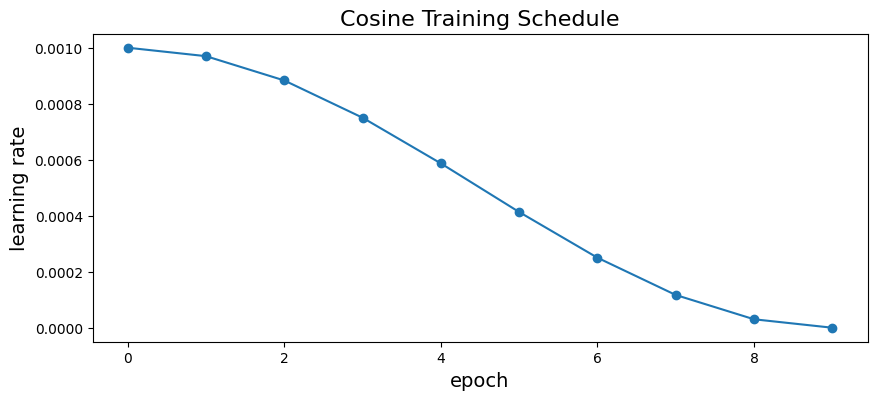

In [ ]:
import math
LR_START = 1e-6
LR_MAX = 1e-3
LR_MIN = 1e-6
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS = 10

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('epoch',size=14); plt.ylabel('learning rate',size=14)
plt.title('Cosine Training Schedule',size=16); plt.show()

LR = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [ ]:
from sklearn.model_selection import KFold, GroupKFold
import tensorflow.keras.backend as K, gc

LOAD_MODELS_FROM

all_oof = []
all_true = []

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(train, train.target, train.patient_id)):

    print('#'*25)
    print(f'### Fold {i+1}')

    train_gen = DataGenerator(train.iloc[train_index], shuffle=True, batch_size=16, augment=False)
    valid_gen = DataGenerator(train.iloc[valid_index], shuffle=False, batch_size=32, mode='valid')

    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)

    K.clear_session()
    with strategy.scope():
        model = build_model()
        # model = build_MixNet_model(36,1,1,1,1)
        model.fit(train_gen, verbose=1,
              validation_data = valid_gen,
              epochs=EPOCHS, callbacks = [LR] )
        model.save_weights(f'Mixnet_36_1_1_1_1_f{i}_computed_specs.h5')

    oof = model.predict(valid_gen, verbose=1)
    all_oof.append(oof)
    all_true.append(train.iloc[valid_index][TARGETS].values)

    del model, oof
    gc.collect()

all_oof = np.concatenate(all_oof)
all_true = np.concatenate(all_true)

#########################
### Fold 1
### train size 13671, valid size 3418
#########################

Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
855/855 [==============================] - 517s 570ms/step - loss: 1.1535 - val_loss: 2.0034 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0009698764640825614.
Epoch 2/10
855/855 [==============================] - 470s 550ms/step - loss: 0.8725 - val_loss: 1.1934 - lr: 9.6988e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0008831391993379295.
Epoch 3/10
855/855 [==============================] - 483s 565ms/step - loss: 0.7702 - val_loss: 1.0895 - lr: 8.8314e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0007502500000000002.
Epoch 4/10
855/855 [==============================] - 494s 578ms/step - loss: 0.7085 - val_loss: 1.1831 - lr: 7.5025e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0005872372647446319.
Epoch 5/10
855/855 [===============

In [ ]:
# np.save("all_oof.npy", all_oof )
# save_file_to_drive("all_oof.npy","all_oof.npy")
# np.save("all_true.npy", all_true )
# save_file_to_drive("all_true.npy","all_true.npy")

for i in range(5):
  save_file_to_drive(f'Mixnet_50_6_12_20_12_f{i}_computed_specs.h5',f'Mixnet_36_1_1_1_1_f{i}_computed_specs.h5')

In [ ]:
'''
This script exists to reduce code duplication across metrics.
'''

import numpy as np
import pandas as pd
import pandas.api.types

from typing import Union


class ParticipantVisibleError(Exception):
    pass


class HostVisibleError(Exception):
    pass


def treat_as_participant_error(error_message: str, solution: Union[pd.DataFrame, np.ndarray]) -> bool:
    ''' Many metrics can raise more errors than can be handled manually. This function attempts
    to identify errors that can be treated as ParticipantVisibleError without leaking any competition data.

    If the solution is purely numeric, and there are no numbers in the error message,
    then the error message is sufficiently unlikely to leak usable data and can be shown to participants.

    We expect this filter to reject many safe messages. It's intended only to reduce the number of errors we need to manage manually.
    '''
    # This check treats bools as numeric
    if isinstance(solution, pd.DataFrame):
        solution_is_all_numeric = all([pandas.api.types.is_numeric_dtype(x) for x in solution.dtypes.values])
        solution_has_bools = any([pandas.api.types.is_bool_dtype(x) for x in solution.dtypes.values])
    elif isinstance(solution, np.ndarray):
        solution_is_all_numeric = pandas.api.types.is_numeric_dtype(solution)
        solution_has_bools = pandas.api.types.is_bool_dtype(solution)

    if not solution_is_all_numeric:
        return False

    for char in error_message:
        if char.isnumeric():
            return False
    if solution_has_bools:
        if 'true' in error_message.lower() or 'false' in error_message.lower():
            return False
    return True


def safe_call_score(metric_function, solution, submission, **metric_func_kwargs):
    '''
    Call score. If that raises an error and that already been specifically handled, just raise it.
    Otherwise make a conservative attempt to identify potential participant visible errors.
    '''
    try:
        score_result = metric_function(solution, submission, **metric_func_kwargs)
    except Exception as err:
        error_message = str(err)
        if err.__class__.__name__ == 'ParticipantVisibleError':
            raise ParticipantVisibleError(error_message)
        elif err.__class__.__name__ == 'HostVisibleError':
            raise HostVisibleError(error_message)
        else:
            if treat_as_participant_error(error_message, solution):
                raise ParticipantVisibleError(error_message)
            else:
                raise err
    return score_result


def verify_valid_probabilities(df: pd.DataFrame, df_name: str):
    """ Verify that the dataframe contains valid probabilities.

    The dataframe must be limited to the target columns; do not pass in any ID columns.
    """
    if not pandas.api.types.is_numeric_dtype(df.values):
        raise ParticipantVisibleError(f'All target values in {df_name} must be numeric')

    if df.min().min() < 0:
        raise ParticipantVisibleError(f'All target values in {df_name} must be at least zero')

    if df.max().max() > 1:
        raise ParticipantVisibleError(f'All target values in {df_name} must be no greater than one')

    if not np.allclose(df.sum(axis=1), 1):
        raise ParticipantVisibleError(f'Target values in {df_name} do not add to one within all rows')

In [ ]:
import numpy as np
import pandas as pd
import pandas.api.types

from typing import Optional


class ParticipantVisibleError(Exception):
    pass


def kl_divergence(solution: pd.DataFrame, submission: pd.DataFrame, epsilon: float, micro_average: bool, sample_weights: Optional[pd.Series]):
    # Overwrite solution for convenience
    for col in solution.columns:
        # Prevent issue with populating int columns with floats
        if not pandas.api.types.is_float_dtype(solution[col]):
            solution[col] = solution[col].astype(float)

        # Clip both the min and max following Kaggle conventions for related metrics like log loss
        # Clipping the max avoids cases where the loss would be infinite or undefined, clipping the min
        # prevents users from playing games with the 20th decimal place of predictions.
        submission[col] = np.clip(submission[col], epsilon, 1 - epsilon)

        y_nonzero_indices = solution[col] != 0
        solution[col] = solution[col].astype(float)
        solution.loc[y_nonzero_indices, col] = solution.loc[y_nonzero_indices, col] * np.log(solution.loc[y_nonzero_indices, col] / submission.loc[y_nonzero_indices, col])
        # Set the loss equal to zero where y_true equals zero following the scipy convention:
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.rel_entr.html#scipy.special.rel_entr
        solution.loc[~y_nonzero_indices, col] = 0

    if micro_average:
        return np.average(solution.sum(axis=1), weights=sample_weights)
    else:
        return np.average(solution.mean())


def score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        row_id_column_name: str,
        epsilon: float=10**-15,
        micro_average: bool=True,
        sample_weights_column_name: Optional[str]=None
    ) -> float:
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    sample_weights = None
    if sample_weights_column_name:
        if sample_weights_column_name not in solution.columns:
            raise ParticipantVisibleError(f'{sample_weights_column_name} not found in solution columns')
        sample_weights = solution.pop(sample_weights_column_name)

    if sample_weights_column_name and not micro_average:
        raise ParticipantVisibleError('Sample weights are only valid if `micro_average` is `True`')

    for col in solution.columns:
        if col not in submission.columns:
            raise ParticipantVisibleError(f'Missing submission column {col}')

    verify_valid_probabilities(solution, 'solution')
    verify_valid_probabilities(submission, 'submission')


    return safe_call_score(kl_divergence, solution, submission, epsilon=epsilon, micro_average=micro_average, sample_weights=sample_weights)

In [ ]:
oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for Model =',cv)

CV Score KL-Div for Model = 0.7879304284147362


# Display Grad Cam
With grad cam, given a specific OOF (out of fold) train sample, we can view both a model's prediction and where it looked to make this prediction. In the plots below we display the image that was fed into our image model, in my popular starter notebook, there are 8 spectrograms that have been tiled into one 1 input image.

On the left we have the 4 Kaggle spectrograms where each is 10 minutes long. Each represents one of the 4 montages LL, RL, LP, RP. (Montages explained [here][1]) On the right, we have the 4 EEG spectrograms where each is 50 seconds long. The EEG spectrograms are made from the Magic Formula [here][2]. The spectrograms are each `128x256x1`, so the final concatenation is `512x512x1`.

![](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/Feb-2024/key2.png)

Each plot below has 3 subplots. The middle and right subplot use the KEY above. The left subplot is just the Grad Cam image where larger values (more yellow) indicates more attention. The middle subplot is the contours of the Grad Cam's 10% largest values superimposed over the image that we fed into our model. The right subplot is also Grad Cam contour superimposed over image but we add an emboss filter to the image to make the details more visible to humans. For explanations about specific grad cam examples, see discussion [here][3]

[1]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467877
[2]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/469760
[3]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/472976

In [ ]:
import cv2

# HELPER FUNCTION
def mask2contour(mask, width=5):
    w = mask.shape[1]
    h = mask.shape[0]
    mask2 = np.concatenate([mask[:,width:],np.zeros((h,width))],axis=1)
    mask2 = np.logical_xor(mask,mask2)
    mask3 = np.concatenate([mask[width:,:],np.zeros((width,w))],axis=0)
    mask3 = np.logical_xor(mask,mask3)
    return np.logical_or(mask2,mask3)

clahe = cv2.createCLAHE(clipLimit=16.0, tileGridSize=(8,8))

In [ ]:
BATCH = 128

for ii,tt in enumerate(TARGETS):
    ttt = tt.split('_')[0].upper()

    print()
    print('#'*25)
    print('###',tt.upper())
    print('#'*25)

    # FIND TRAIN SAMPLES IN OOF (OUT OF FOLD) WITH TARGET >= 0.5
    IDX = train.loc[train.index.isin(valid_index) & (train[tt]>=0.5),TARGETS].index.values
    print(f'Found {len(IDX)} samples in fold zero OOF for {tt} with true>0.5')

    # INFER TRAIN SAMPLES WITH MODEL (SAVE PREDS AND ACTIVATIONS)
    valid_gen = DataGenerator(train.iloc[IDX[:128]], shuffle=False, batch_size=BATCH, mode='valid')
    p,xx = model.predict(valid_gen,verbose=0)
    #print(xx.shape)

    # DISPLAY GRAD CAM
    for x,y in valid_gen:
        ct = 0
        for i in range(BATCH):

            # FIND SAMPLES WITH PRED >= 0.5 FOR TARGET
            if i>=len(p): continue
            pred = p[i]
            if pred[ii]<0.5: continue

            # FORMAT PREDICTIONS AS STRING
            pred2 = ''; true2 = ''
            true = train.loc[IDX[i]][TARGETS].values
            for j,t in enumerate(TARGETS):
                n = t.split('_')[0]
                pred2 += f' {n}={pred[j]:0.3f}'
                true2 += f' {n}={true[j]:0.3f}'
            print()
            print('==> TRUE:',true2)
            print('==> PRED:',pred2)

            # PLOT GRAD CAM RESULTS
            plt.figure(figsize=(20,8))

            # PLOT GRAD CAM IMAGE (PLOT 1 OF 3)
            plt.subplot(1,3,1)
            img = np.sum(xx[i,] * layer_weights,axis=-1)
            img = cv2.resize(img,(512,512))
            plt.imshow(img[::-1,])
            plt.title(f'{ttt} - Grad Cam',size=14)

            # FIND GRAD CAM CONTOURS FOR AREAS OF INTEREST
            cut = np.percentile(img.flatten(), [90])[0]
            cntr = img.copy()
            cntr[cntr>=cut] = 100
            cntr[cntr<cut] = 0
            cntr = mask2contour(cntr)

            # PLOT EMBOSSED SPECTROGRAMS WITH GRADCAM CONTOURS (PLOT 3 OF 3)
            plt.subplot(1,3,3)
            x1 = [x[i,:,:,k:k+1] for k in range(4)] #KAGGLE-SPECS: LL RL LP RP
            x1 = np.concatenate(x1,axis=0)
            x2 = [x[i,:,:,k+4:k+5] for k in range(4)] #EEG-SPECS: LL LP RL RP
            x2 = np.concatenate(x2,axis=0)
            x3 = np.concatenate([x1,x2],axis=1)
            img = cv2.resize(x3,(512,512))
            img0 = img.copy()

            # EMBOSS IMAGE FOR IMAGE FEATURE VISIBILITY
            img = img[1:,1:] - img[:-1,:-1] #emboss
            img -= np.min(img)
            img /= np.max(img)
            img = (img*255).astype('uint8')
            img = cv2.GaussianBlur(img,(5,5),0)
            img = clahe.apply(img)
            mx = np.max(img)

            cntr2 = cntr[1:,1:]
            img[cntr2>0] = mx
            plt.imshow(img[::-1,])
            plt.title(f'{ttt} - Embossed Spectrogram with Grad Cam Contours',size=14)

            # PLOT SPECTROGRAMS WITH GRADCAM CONTOURS (PLOT 2 OF 3)
            plt.subplot(1,3,2)
            mx = np.max(img0)
            img0[cntr>0] = mx
            plt.imshow(img0[::-1,])
            plt.title(f'{ttt} - Spectrogram with Grad Cam Contours',size=14)

            plt.show()
            ct += 1
            if ct==8: break

        break